In [6]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 47.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 47.3 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into a

In [26]:
pip install matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


In [13]:
import random
from PIL import Image, ImageFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
def augment(input_diretory_path):

    def pixelate(input_image_path, pixel_size=5):
        with Image.open(input_image_path) as image:
            # Calculate the size of the pixelated image, reducing its resolution
            small_image = image.resize(
                (image.width // pixel_size, image.height // pixel_size),
                resample=Image.BILINEAR
            )

            # Scale it back to the original size
            result_image = small_image.resize(
                image.size,
                Image.NEAREST
            )
            if result_image.mode == 'RGBA':
                result_image = result_image.convert('RGB')
            path_parts = input_image_path.split('/')
            output_image_path = "/kaggle/working/" + path_parts[-1] + "_pixelated.jpg"
            # Save the pixelated image
            result_image.save(output_image_path)

    def add_grain(input_image_path, grain_level=5):
        # Open the image
        with Image.open(input_image_path) as image:
            # Convert the image into a numpy array
            image_array = np.array(image)

            # Generate noise array, scaled by the grain level
            noise = np.random.randint(-grain_level, grain_level, image_array.shape, dtype='int16')

            # Add noise to the image array, ensuring values stay in the [0, 255] range
            noisy_image_array = image_array.astype('int16') + noise
            noisy_image_array = np.clip(noisy_image_array, 0, 255)

            # Convert the noisy image array back into an image
            noisy_image = Image.fromarray(noisy_image_array.astype('uint8'))

            if noisy_image.mode == 'RGBA':
                noisy_image = noisy_image.convert('RGB')
            path_parts = input_image_path.split('/')
            output_image_path = "/kaggle/working/" + path_parts[-1] + "_grainy.jpg"
            # Save the grainy image
            noisy_image.save(output_image_path)

    def blur_image(input_image_path, blur_radius=5):
        with Image.open(input_image_path) as image:
            # Apply the blur filter with the specified blur radius
            blurred_image = image.filter(ImageFilter.GaussianBlur(blur_radius))
            if blurred_image.mode == 'RGBA':
                blurred_image = blurred_image.convert('RGB')
            path_parts = input_image_path.split('/')
            output_image_path = "/kaggle/working/" + path_parts[-1] + "_blurred.jpg"

            # Save the blurred image
            blurred_image.save(output_image_path)

    def motion_blur(image_path, intensity=10, angle=30):
        image = cv2.imread(image_path)
        # Generating the motion blur kernel
        kernel_size = intensity
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
        kernel = cv2.warpAffine(kernel, cv2.getRotationMatrix2D((kernel_size / 2 - 0.5, kernel_size / 2 - 0.5), angle, 1.0), (kernel_size, kernel_size))
        kernel = kernel / kernel_size

        # Applying the kernel to the input image
        blurred_image = cv2.filter2D(image, -1, kernel)

        path_parts = image_path.split('/')
        output_image_path = "/kaggle/working/" + path_parts[-1] + "_motion_blurred.jpg"
        cv2.imwrite(output_image_path, blurred_image)  # Save the blurred image in the specified output directory


    def lens_flare(image_path):
        def seed_everything(seed):
            random.seed(seed)
            os.environ['PYTHONHASHSEED'] = str(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = True

        def visualize(image):
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(image)

        def visualize_multiple(nrows, ncols, img, transform):
            fig, axes = plt.subplots(nrows,ncols)
            fig.set_figheight(15)
            fig.set_figwidth(15)
            num_iter = 0
            for row in range(nrows):
                for col in range(ncols):
                    augmented_img = transform[num_iter](image=img)['image']
                    axes[row,col].imshow(augmented_img)
                    axes[row,col].grid(False)
                    axes[row,col].set_xticks([])
                    axes[row,col].set_yticks([])
                    num_iter += 1
            return fig, axes

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        transform = [A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5),
                                      angle_lower=0, angle_upper=1,
                                      num_flare_circles_lower=6,
                                      num_flare_circles_upper=10,
                                      src_radius=400, src_color=(255, 255, 255),
                                      always_apply=True) for _ in range(9)]
        path_parts = image_path.split('/')
        output_image_path = "/kaggle/working/" + path_parts[-1] + "_lens_flare.jpg"

        # Apply the first transformation in the list to the image
        augmented_img = transform[random.randint(0, len(transform))-1](image=img)['image']

        # Save the transformed image as a .jpg file
        cv2.imwrite(output_image_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))


    num_of_files = 0
    num_of_files_limit = 50
    files  = [os.listdir(input_diretory_path)][0]
    for filename in files:
        if(num_of_files < num_of_files_limit):
            # print(image_path)
            image_path = os.path.join(input_diretory_path, filename)
            pixelate(image_path, pixel_size=5)
            add_grain(image_path, grain_level=30)
            blur_image(image_path, blur_radius=2)
            motion_blur(image_path)
            lens_flare(image_path)
            num_of_files+=1

In [4]:
augment("/kaggle/input/adobe-fivek/a")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  


In [42]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
# We'll use the output of the last convolutional block as the feature
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Directory containing images
directory = '/kaggle/working/'

# Function to load and preprocess the image
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resizing to 224x224 which is required by ResNet50
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)  # Preprocess the image

# Function to extract features
def extract_features(img_path):
    img = load_and_preprocess_img(img_path)
    features = model.predict(img)
    return features.flatten()  # Flatten the features to a 1D array

# Loop through each file in the directory and extract features
features_dict = {}
for filename in os.listdir(directory):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_path = os.path.join(directory, filename)
        features = extract_features(file_path)
        features_dict[filename] = features

print("Features extracted for all images.")

Features extracted for all images.


In [33]:
data = {'filename': list(features_dict.keys()), 'features': list(features_dict.values())}

# Create DataFrame
df_a = pd.DataFrame(data)

# Optionally, you can split the features into separate columns if needed
# For example, if each feature array has 2048 elements (typical for ResNet50 'avg_pool'):
feature_columns = [f'feature_{i}' for i in range(len(df_a['features'].iloc[0]))]
df_a[feature_columns] = pd.DataFrame(df_a['features'].tolist(), index=df_a.index)

# Dropping the original 'features' column if it's no longer needed
df_a.drop('features', axis=1, inplace=True)

df_a

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


filename  feature_0  feature_1  \
0                       a1380-jmac_DSC0493.jpg   0.847715   0.552176   
1     a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.151609   1.161677   
2                           a3683-KE_-0037.jpg   0.123358   0.725567   
3      a0619-20081019_at_01h22m56__MG_3327.jpg   0.000000   0.849179   
4                 a4881-Duggan_090405_7225.jpg   0.714135   0.000000   
...                                        ...        ...        ...   
4995                         a3440-kme_407.jpg   1.114875   1.359866   
4996                        a2430-_DGW6240.jpg   1.454424   0.002264   
4997                        a0994-IMG_4703.jpg   1.657275   0.129625   
4998   a4692-20090321_at_16h01m53__MG_0133.jpg   0.177588   0.679395   
4999                         a3141-dvf_079.jpg   0.926947   0.828157   

      feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0      1.155910   0.593454   0.535424   0.902732   0.479701   0.540000   
1      0.236279   1.201173   0.680420   1.322529   0.639451   1.236349   
2      0.162051   2.412416   0.234578   0.080802   0.012345   1.794962   
3      1.459018   0.049352   0.100921   0.217932   1.203306   1.364567   
4      0.222913   0.000000   0.135649   0.944693   0.262582   1.004278   
...         ...        ...        ...        ...        ...        ...   
4995   0.055568   0.000000   0.080577   0.000000   0.159787   0.845149   
4996   2.042056   0.002895   0.004409   0.000000   0.134429   0.111569   
4997   0.964397   0.000000   0.049000   0.218091   0.481128   0.264281   
4998   0.399415   0.685569   0.107826   0.930966   0.008227   0.469102   
4999   0.600277   0.004086   0.000000   0.416129   0.000000   0.143310   

      feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0      1.972688  ...      0.052140      0.016526      2.205877      0.313320   
1      1.000782  ...      0.000000      0.537745      1.100954      1.144634   
2      4.252037  ...      0.128928      0.026402      0.428126      0.622625   
3      0.732869  ...      0.000000      0.283763      2.011308      1.425277   
4      1.121245  ...      0.082653      0.000000      1.169199      0.059584   
...         ...  ...           ...           ...           ...           ...   
4995   0.040389  ...      0.627730      0.000000      0.026553      0.016638   
4996   0.149221  ...      0.374721      0.758925      0.276434      0.257414   
4997   0.094475  ...      0.460615      0.000000      0.000000      0.017509   
4998   0.109918  ...      0.039031      0.143502      0.000000      1.365602   
4999   0.342219  ...      0.000000      0.064346      0.157851      0.175536   

      feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0         0.332020      0.241766      2.745939      0.271787      0.406695   
1         0.201663      0.005133      0.611328      1.198680      0.241484   
2         1.451485      0.135056      0.365355      0.000957      0.641948   
3         0.235654      0.829455      0.395769      0.000000      0.341011   
4         2.195289      0.000000      2.223164      0.447294      0.056132   
...            ...           ...           ...           ...           ...   
4995      0.455478      0.353650      5.166523      0.012285      0.850371   
4996      0.000000      0.030567      0.000000      0.186958      0.252582   
4997      0.375926      0.667674      0.471933      0.078522      0.214427   
4998      0.812603      0.448171      0.441379      0.798265      1.668550   
4999      0.239733      0.000000      0.000000      0.202895      0.181526   

      feature_2047  
0         0.141644  
1         0.178305  
2         0.648716  
3         3.537009  
4         0.404334  
...            ...  
4995      0.210624  
4996      0.198300  
4997      0.202677  
4998      0.521937  
4999      0.000000  

[5000 rows x 2049 columns]

In [35]:
data = {'filename': list(features_dict.keys()), 'features': list(features_dict.values())}

# Create DataFrame
df_b = pd.DataFrame(data)

# Optionally, you can split the features into separate columns if needed
# For example, if each feature array has 2048 elements (typical for ResNet50 'avg_pool'):
feature_columns = [f'feature_{i}' for i in range(len(df_b['features'].iloc[0]))]
df_b[feature_columns] = pd.DataFrame(df_b['features'].tolist(), index=df_b.index)

# Dropping the original 'features' column if it's no longer needed
df_b.drop('features', axis=1, inplace=True)

df_b

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


filename  feature_0  feature_1  \
0                       a1380-jmac_DSC0493.jpg   0.969646   0.416368   
1     a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.117797   1.144573   
2                           a3683-KE_-0037.jpg   0.096934   0.903911   
3      a0619-20081019_at_01h22m56__MG_3327.jpg   0.018715   1.108634   
4                 a4881-Duggan_090405_7225.jpg   0.354522   0.000000   
...                                        ...        ...        ...   
2496                 a3187-MB_20030906_085.jpg   0.045232   0.509710   
2497                        a2399-IMG_4974.jpg   2.665629   0.045091   
2498                        a4203-_DGW0246.jpg   0.064932   2.801823   
2499                         a3492-kme_180.jpg   0.137333   0.635989   
2500             a1665-jn_20080821_NYC_006.jpg   0.252066   0.081914   

      feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0      0.860759   0.562935   0.470263   0.951128   0.523686   0.339280   
1      0.250283   1.454315   0.842801   1.375921   0.510035   1.363492   
2      0.142869   2.321478   0.209339   0.087335   0.000000   1.691602   
3      0.741119   0.215526   0.058712   0.190128   1.152879   1.278430   
4      0.079257   0.093635   0.023540   0.796171   0.165576   0.364355   
...         ...        ...        ...        ...        ...        ...   
2496   0.007429   0.111026   0.026796   0.791173   0.037103   0.244732   
2497   1.691023   0.287200   0.006716   0.003998   0.385529   0.000004   
2498   0.000000   1.411165   0.020138   1.927096   0.203103   3.350252   
2499   0.327886   1.592771   0.957381   0.071434   0.285457   1.184784   
2500   0.270036   0.023407   0.020434   0.084554   0.160802   0.107298   

      feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0      2.222443  ...      0.001417      0.092455      2.311389      0.598559   
1      1.177721  ...      0.000000      0.402974      0.877974      1.189432   
2      4.564048  ...      0.021996      0.015583      0.574979      0.771167   
3      1.430917  ...      0.074244      0.101261      1.983079      2.240344   
4      1.275773  ...      0.000000      0.000000      1.304657      0.051136   
...         ...  ...           ...           ...           ...           ...   
2496   0.140355  ...      0.013627      0.000000      0.321306      0.159348   
2497   0.165432  ...      1.261707      0.000000      0.008469      0.082925   
2498   0.401430  ...      0.018049      0.235566      0.776224      1.362142   
2499   1.162817  ...      0.362696      0.000000      0.242084      0.493542   
2500   0.773870  ...      0.000000      0.219801      1.090435      0.057072   

      feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0         0.346242      0.403471      2.075617      0.715370      0.981973   
1         0.163128      0.028664      0.395096      1.691171      0.269771   
2         1.545031      0.203110      0.384659      0.010529      0.480476   
3         0.057726      0.577004      0.661066      0.130082      0.449080   
4         1.564464      0.000000      2.412411      0.309794      0.000000   
...            ...           ...           ...           ...           ...   
2496      0.633311      0.000000      0.048017      0.680702      0.558129   
2497      0.239083      0.009126      0.007597      1.232144      0.001054   
2498      0.727479      0.005684      0.102445      0.308823      0.433979   
2499      1.575408      0.005419      0.397935      5.800890      1.760311   
2500      0.230544      0.007957      1.041475      0.039965      0.040726   

      feature_2047  
0         0.227715  
1         0.226957  
2         0.703867  
3         3.272599  
4         0.280826  
...            ...  
2496      0.800726  
2497      1.500153  
2498      0.114997  
2499      0.738647  
2500      0.005312  

[2501 rows x 2049 columns]

In [39]:
data = {'filename': list(features_dict.keys()), 'features': list(features_dict.values())}

# Create DataFrame
df_c = pd.DataFrame(data)

# Optionally, you can split the features into separate columns if needed
# For example, if each feature array has 2048 elements (typical for ResNet50 'avg_pool'):
feature_columns = [f'feature_{i}' for i in range(len(df_c['features'].iloc[0]))]
df_c[feature_columns] = pd.DataFrame(df_c['features'].tolist(), index=df_c.index)

# Dropping the original 'features' column if it's no longer needed
df_c.drop('features', axis=1, inplace=True)

df_c

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


filename  feature_0  feature_1  \
0                      a1380-jmac_DSC0493.jpg   1.079622   0.252450   
1    a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.095690   1.119514   
2                          a3683-KE_-0037.jpg   0.120426   0.917766   
3     a0619-20081019_at_01h22m56__MG_3327.jpg   0.016759   0.835467   
4                a4881-Duggan_090405_7225.jpg   0.298856   0.000000   
..                                        ...        ...        ...   
995                        a2190-DSC_0074.jpg   0.170853   0.199047   
996                        a0766-_DGW6227.jpg   2.674434   0.481853   
997                        a4630-_DSC0025.jpg   0.020745   0.033084   
998                        a2918-_I2E7066.jpg   0.533310   0.585783   
999                        a2690-IMG_0260.jpg   0.604116   0.466759   

     feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0     0.608182   0.406338   0.501310   1.066870   0.562031   0.306418   
1     0.147255   1.777392   0.758353   1.687865   0.547477   1.125883   
2     0.170352   2.821736   0.223278   0.131779   0.074022   1.054116   
3     1.058931   0.147794   0.016122   0.382145   1.749554   1.477430   
4     0.100127   0.169595   0.024894   0.393207   0.083542   0.672566   
..         ...        ...        ...        ...        ...        ...   
995   0.505970   0.000000   0.119903   0.111474   0.501732   0.640710   
996   2.800327   0.113325   1.108590   0.052496   0.099337   2.288812   
997   1.383407   1.851581   0.192960   0.100777   0.568863   0.153915   
998   0.131901   0.182547   0.032079   0.027078   0.526329   0.287469   
999   0.207512   2.614125   0.034287   0.598248   0.814634   0.703374   

     feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0     1.936538  ...      0.000360      0.084544      2.458948      0.316536   
1     1.170471  ...      0.000000      0.622322      0.770749      0.995975   
2     5.631580  ...      0.089152      0.013098      0.494945      0.949562   
3     0.955545  ...      0.206292      0.061675      2.162535      0.940193   
4     1.162943  ...      0.186238      0.000000      0.947580      0.035243   
..         ...  ...           ...           ...           ...           ...   
995   2.341153  ...      0.020068      0.196687      0.295012      0.575421   
996   0.346813  ...      2.530727      1.133462      0.547669      0.018467   
997   0.367986  ...      0.106609      0.249398      3.541520      0.115675   
998   0.309175  ...      0.000000      0.080197      0.030957      0.521736   
999   0.621895  ...      0.035758      0.249116      1.181429      0.204550   

     feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0        0.231587      0.592739      1.803013      0.443849      1.182130   
1        0.294793      0.009040      0.443851      1.392082      0.363694   
2        1.670804      0.220111      0.983242      0.013971      0.432470   
3        0.165180      0.448869      0.218644      0.129099      0.454996   
4        1.839015      0.000000      2.073560      0.570620      0.077455   
..            ...           ...           ...           ...           ...   
995      0.170672      0.069848      1.661298      1.366036      0.382631   
996      0.123118      1.815866      0.000000      0.780221      0.965327   
997      1.042204      0.536763      2.189441      0.408654      0.105192   
998      0.060668      0.044060      0.644485      0.506499      0.266970   
999      0.038581      0.923590      3.327834      0.284237      0.574172   

     feature_2047  
0        0.178831  
1        0.203523  
2        0.682866  
3        3.187836  
4        0.277339  
..            ...  
995      0.103810  
996      0.143852  
997      0.071563  
998      0.625886  
999      1.265645  

[1000 rows x 2049 columns]

In [37]:
data = {'filename': list(features_dict.keys()), 'features': list(features_dict.values())}

# Create DataFrame
df_d = pd.DataFrame(data)

# Optionally, you can split the features into separate columns if needed
# For example, if each feature array has 2048 elements (typical for ResNet50 'avg_pool'):
feature_columns = [f'feature_{i}' for i in range(len(df_d['features'].iloc[0]))]
df_d[feature_columns] = pd.DataFrame(df_d['features'].tolist(), index=df_d.index)

# Dropping the original 'features' column if it's no longer needed
df_d.drop('features', axis=1, inplace=True)

df_d

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


filename  feature_0  feature_1  \
0                      a1380-jmac_DSC0493.jpg   1.079622   0.252450   
1    a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.095690   1.119514   
2                          a3683-KE_-0037.jpg   0.120426   0.917766   
3     a0619-20081019_at_01h22m56__MG_3327.jpg   0.016759   0.835467   
4                a4881-Duggan_090405_7225.jpg   0.298856   0.000000   
..                                        ...        ...        ...   
495        a1847-20051222_141305__MG_0341.jpg   0.532156   0.274607   
496                         a0180-kme_307.jpg   0.493401   0.684517   
497   a3036-20090127_at_17h54m33__MG_4036.jpg   0.347528   0.111378   
498                         a3651-kme_579.jpg   0.548663   0.398124   
499                    a2358-jmac_MG_0546.jpg   0.076867   0.000000   

     feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0     0.608182   0.406338   0.501310   1.066870   0.562031   0.306418   
1     0.147255   1.777392   0.758353   1.687865   0.547477   1.125883   
2     0.170352   2.821736   0.223278   0.131779   0.074022   1.054116   
3     1.058931   0.147794   0.016122   0.382145   1.749554   1.477430   
4     0.100127   0.169595   0.024894   0.393207   0.083542   0.672566   
..         ...        ...        ...        ...        ...        ...   
495   0.085504   1.419756   0.000000   0.213814   0.304290   0.074126   
496   0.548870   0.055265   0.916940   0.086650   1.402869   0.231039   
497   0.009590   1.911379   0.191522   0.000000   0.182600   0.394763   
498   0.084602   0.000000   0.177539   0.041832   0.368123   0.038963   
499   0.112693   0.000000   0.763830   0.000000   0.664464   0.037839   

     feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0     1.936538  ...      0.000360      0.084544      2.458948      0.316536   
1     1.170471  ...      0.000000      0.622322      0.770749      0.995975   
2     5.631580  ...      0.089152      0.013098      0.494945      0.949562   
3     0.955545  ...      0.206292      0.061675      2.162535      0.940193   
4     1.162943  ...      0.186238      0.000000      0.947580      0.035243   
..         ...  ...           ...           ...           ...           ...   
495   0.144736  ...      0.000525      0.079463      3.149184      0.000000   
496   0.345170  ...      0.102895      1.205188      1.628947      0.107440   
497   0.000000  ...      0.173171      0.000000      1.564305      5.466143   
498   0.614201  ...      0.000000      0.087273      0.057848      0.000000   
499   1.921732  ...      0.009868      0.003784      1.518175      0.393617   

     feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0        0.231587      0.592739      1.803013      0.443849      1.182130   
1        0.294793      0.009040      0.443851      1.392082      0.363694   
2        1.670804      0.220111      0.983242      0.013971      0.432470   
3        0.165180      0.448869      0.218644      0.129099      0.454996   
4        1.839015      0.000000      2.073560      0.570620      0.077455   
..            ...           ...           ...           ...           ...   
495      0.330436      0.000000      3.807202      0.273977      0.000000   
496      0.207581      1.124056      0.424905      0.081886      0.310129   
497      0.366637      0.192698      0.044761      0.083510      0.056867   
498      0.036407      0.032184      0.013683      0.033406      0.157587   
499      0.000000      0.092479      1.154429      1.731858      0.361919   

     feature_2047  
0        0.178831  
1        0.203523  
2        0.682866  
3        3.187836  
4        0.277339  
..            ...  
495      0.719850  
496      1.078041  
497      0.001506  
498      0.526033  
499      0.075658  

[500 rows x 2049 columns]

In [41]:
data = {'filename': list(features_dict.keys()), 'features': list(features_dict.values())}

# Create DataFrame
df_e = pd.DataFrame(data)

# Optionally, you can split the features into separate columns if needed
# For example, if each feature array has 2048 elements (typical for ResNet50 'avg_pool'):
feature_columns = [f'feature_{i}' for i in range(len(df_e['features'].iloc[0]))]
df_e[feature_columns] = pd.DataFrame(df_e['features'].tolist(), index=df_e.index)

# Dropping the original 'features' column if it's no longer needed
df_e.drop('features', axis=1, inplace=True)

df_e

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


filename  feature_0  feature_1  \
0                      a1380-jmac_DSC0493.jpg   0.572669   0.358105   
1    a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.123212   1.030575   
2                          a3683-KE_-0037.jpg   0.210823   1.382436   
3     a0619-20081019_at_01h22m56__MG_3327.jpg   0.002080   1.292182   
4                a4881-Duggan_090405_7225.jpg   0.875555   0.020319   
..                                        ...        ...        ...   
245                         a0112-kme_093.jpg   1.033131   0.071126   
246                    a1621-jmac_MG_0344.jpg   1.269211   0.036066   
247                        a1186-IMG_5553.jpg   0.359506   0.000000   
248                        a3641-_DSC4628.jpg   0.356226   1.333164   
249          a0810-050713_234914__I2E3846.jpg   0.000000   0.240984   

     feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0     0.757705   0.351388   0.324443   0.938854   0.511556   0.374179   
1     0.244647   1.679133   0.857864   1.435210   0.512163   1.334952   
2     0.304119   2.363042   0.209478   0.006115   0.048434   1.240905   
3     1.047168   0.422395   0.058368   0.279258   1.345694   1.255328   
4     0.145019   0.000000   0.265102   1.099204   0.529508   0.774710   
..         ...        ...        ...        ...        ...        ...   
245   0.015538   0.824857   0.272175   0.478015   0.579493   0.004395   
246   1.563075   1.211109   0.146685   0.330283   0.000000   0.110305   
247   0.465218   0.221987   0.100136   0.196602   0.041524   0.008606   
248   0.580121   0.040455   1.146362   0.093565   0.165861   0.461364   
249   0.082350   0.725502   0.202732   0.000000   0.000000   0.436355   

     feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0     2.144988  ...      0.000000      0.020983      1.933517      0.416910   
1     1.055790  ...      0.000000      0.383096      0.942386      1.305826   
2     4.066006  ...      0.115688      0.003778      0.825869      0.534419   
3     1.067654  ...      0.161781      0.002202      2.087488      1.439693   
4     1.154350  ...      0.269169      0.000000      1.352166      0.146489   
..         ...  ...           ...           ...           ...           ...   
245   0.410162  ...      0.576147      0.033582      0.061844      0.029331   
246   0.177645  ...      0.015261      0.061500      1.724207      0.077330   
247   2.647304  ...      0.038151      0.145484      0.592592      0.045496   
248   1.328845  ...      0.142232      0.816787      0.171226      0.048019   
249   0.078701  ...      0.055298      0.235967      2.250724      1.628518   

     feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0        0.223866      0.195409      1.476642      0.422079      0.751111   
1        0.182646      0.040737      0.350970      1.966778      0.273744   
2        1.931891      0.177038      0.358899      0.000000      0.327974   
3        0.137269      0.470364      0.427405      0.182204      0.512714   
4        1.449630      0.014464      1.698367      0.113980      0.075166   
..            ...           ...           ...           ...           ...   
245      0.320009      0.005723      0.272607      0.048180      0.040400   
246      0.177573      0.479475      1.035637      0.332749      0.436722   
247      0.115034      0.044406      0.113729      0.957469      0.180696   
248      0.010618      0.033032      0.143199      0.447032      0.489291   
249      0.536748      0.000000      0.175189      0.454298      0.710818   

     feature_2047  
0        0.206355  
1        0.272663  
2        0.637444  
3        3.682922  
4        0.626936  
..            ...  
245      0.062044  
246      0.551910  
247      0.997019  
248      0.191843  
249      0.670361  

[250 rows x 2049 columns]

In [43]:
data = {'filename': list(features_dict.keys()), 'features': list(features_dict.values())}

# Create DataFrame
df_aug = pd.DataFrame(data)

# Optionally, you can split the features into separate columns if needed
# For example, if each feature array has 2048 elements (typical for ResNet50 'avg_pool'):
feature_columns = [f'feature_{i}' for i in range(len(df_aug['features'].iloc[0]))]
df_aug[feature_columns] = pd.DataFrame(df_aug['features'].tolist(), index=df_aug.index)

# Dropping the original 'features' column if it's no longer needed
df_aug.drop('features', axis=1, inplace=True)

df_aug

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


filename  feature_0  feature_1  \
0                   a2403-dgw_095.jpg_lens_flare.jpg   2.364521   1.009179   
1                     a3851-IMG_3430.jpg_blurred.jpg   0.000000   0.452221   
2                  a4801-_DGW0327.jpg_lens_flare.jpg   0.000000   0.568895   
3                    a2177-kme_386.jpg_pixelated.jpg   0.141654   0.276653   
4               a2612-dgw_115.jpg_motion_blurred.jpg   2.302223   1.149331   
..                                               ...        ...        ...   
245             a2311-kme_559.jpg_motion_blurred.jpg   0.165460   0.212360   
246  a4881-Duggan_090405_7225.jpg_motion_blurred.jpg   1.026439   0.006755   
247                 a2726-kme_277.jpg_lens_flare.jpg   1.193474   2.652498   
248                a0537-IMG_1562.jpg_lens_flare.jpg   0.270977   0.673120   
249                 a4801-_DGW0327.jpg_pixelated.jpg   0.070940   0.674321   

     feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0     0.122019   0.515632   0.013369   0.998529   0.409151   0.000000   
1     0.000000   0.374166   0.164700   0.298621   0.153779   0.972704   
2     0.062502   0.804014   0.507772   0.000000   0.000000   0.405611   
3     0.047383   0.588545   1.428930   0.092050   0.062837   0.000000   
4     2.241790   0.087843   0.528200   0.079862   0.297889   0.418325   
..         ...        ...        ...        ...        ...        ...   
245   0.000000   0.334257   0.147645   0.145441   1.890323   0.212706   
246   0.280159   0.019175   0.233184   1.283669   0.292250   0.484506   
247   0.165280   2.340047   0.236165   1.565924   0.626812   0.578797   
248   0.588138   0.000000   0.185713   0.378058   0.060259   0.458555   
249   1.006944   1.153079   0.315862   0.991693   0.065632   0.261395   

     feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0     0.314529  ...      0.000000      0.000000      0.373358      0.057515   
1     0.000000  ...      0.000000      0.000000      0.111461      1.653890   
2     0.089544  ...      0.000000      0.366926      0.702779      0.492558   
3     0.019864  ...      0.038528      0.002184      0.003366      0.267987   
4     0.784329  ...      0.381911      0.302455      0.495073      0.008299   
..         ...  ...           ...           ...           ...           ...   
245   0.895615  ...      0.013681      0.050033      0.388174      0.000000   
246   1.208081  ...      0.044743      0.000000      0.873931      0.039824   
247   3.854193  ...      0.091018      0.017618      0.000000      0.001689   
248   0.589197  ...      0.000000      0.045787      1.189458      0.817592   
249   0.099204  ...      0.111299      0.370608      0.203690      2.112113   

     feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0        0.371794      1.718667      1.963884      2.795229      0.413802   
1        0.046596      0.346331      0.548086      0.046291      0.022033   
2        0.104274      0.960095      0.098030      1.343707      0.030690   
3        0.101094      0.102877      0.642058      0.181884      0.106612   
4        0.025330      1.125474      0.000000      0.145485      0.899660   
..            ...           ...           ...           ...           ...   
245      0.535410      0.014719      2.122653      0.290323      0.000000   
246      1.502171      0.000000      2.677045      0.705415      0.059748   
247      0.464067      0.714830      0.029037      1.195534      2.301097   
248      1.208669      0.300917      1.174797      1.825034      0.655038   
249      0.678159      1.618609      0.318337      2.099776      0.290634   

     feature_2047  
0        0.466159  
1        0.075564  
2        0.129147  
3        0.007887  
4        0.231234  
..            ...  
245      0.171432  
246      0.719598  
247      1.513492  
248      0.245678  
249      0.820551  

[250 rows x 2049 columns]

In [44]:
df = pd.concat([df_a, df_b, df_c, df_d, df_e, df_aug])
df

filename  feature_0  feature_1  \
0                             a1380-jmac_DSC0493.jpg   0.847715   0.552176   
1           a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.151609   1.161677   
2                                 a3683-KE_-0037.jpg   0.123358   0.725567   
3            a0619-20081019_at_01h22m56__MG_3327.jpg   0.000000   0.849179   
4                       a4881-Duggan_090405_7225.jpg   0.714135   0.000000   
..                                               ...        ...        ...   
245             a2311-kme_559.jpg_motion_blurred.jpg   0.165460   0.212360   
246  a4881-Duggan_090405_7225.jpg_motion_blurred.jpg   1.026439   0.006755   
247                 a2726-kme_277.jpg_lens_flare.jpg   1.193474   2.652498   
248                a0537-IMG_1562.jpg_lens_flare.jpg   0.270977   0.673120   
249                 a4801-_DGW0327.jpg_pixelated.jpg   0.070940   0.674321   

     feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0     1.155910   0.593454   0.535424   0.902732   0.479701   0.540000   
1     0.236279   1.201173   0.680420   1.322529   0.639451   1.236349   
2     0.162051   2.412416   0.234578   0.080802   0.012345   1.794962   
3     1.459018   0.049352   0.100921   0.217932   1.203306   1.364567   
4     0.222913   0.000000   0.135649   0.944693   0.262582   1.004278   
..         ...        ...        ...        ...        ...        ...   
245   0.000000   0.334257   0.147645   0.145441   1.890323   0.212706   
246   0.280159   0.019175   0.233184   1.283669   0.292250   0.484506   
247   0.165280   2.340047   0.236165   1.565924   0.626812   0.578797   
248   0.588138   0.000000   0.185713   0.378058   0.060259   0.458555   
249   1.006944   1.153079   0.315862   0.991693   0.065632   0.261395   

     feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0     1.972688  ...      0.052140      0.016526      2.205877      0.313320   
1     1.000782  ...      0.000000      0.537745      1.100954      1.144634   
2     4.252037  ...      0.128928      0.026402      0.428126      0.622625   
3     0.732869  ...      0.000000      0.283763      2.011308      1.425277   
4     1.121245  ...      0.082653      0.000000      1.169199      0.059584   
..         ...  ...           ...           ...           ...           ...   
245   0.895615  ...      0.013681      0.050033      0.388174      0.000000   
246   1.208081  ...      0.044743      0.000000      0.873931      0.039824   
247   3.854193  ...      0.091018      0.017618      0.000000      0.001689   
248   0.589197  ...      0.000000      0.045787      1.189458      0.817592   
249   0.099204  ...      0.111299      0.370608      0.203690      2.112113   

     feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0        0.332020      0.241766      2.745939      0.271787      0.406695   
1        0.201663      0.005133      0.611328      1.198680      0.241484   
2        1.451485      0.135056      0.365355      0.000957      0.641948   
3        0.235654      0.829455      0.395769      0.000000      0.341011   
4        2.195289      0.000000      2.223164      0.447294      0.056132   
..            ...           ...           ...           ...           ...   
245      0.535410      0.014719      2.122653      0.290323      0.000000   
246      1.502171      0.000000      2.677045      0.705415      0.059748   
247      0.464067      0.714830      0.029037      1.195534      2.301097   
248      1.208669      0.300917      1.174797      1.825034      0.655038   
249      0.678159      1.618609      0.318337      2.099776      0.290634   

     feature_2047  
0        0.141644  
1        0.178305  
2        0.648716  
3        3.537009  
4        0.404334  
..            ...  
245      0.171432  
246      0.719598  
247      1.513492  
248      0.245678  
249      0.820551  

[9501 rows x 2049 columns]

In [45]:
df.to_csv("features.csv")

In [46]:
import os
print(os.getcwd())


/kaggle/working


In [72]:
df = pd.read_csv("/kaggle/input/features/features.csv")
df

Unnamed: 0                                         filename  feature_0  \
0              0                           a1380-jmac_DSC0493.jpg   0.847715   
1              1         a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.151609   
2              2                               a3683-KE_-0037.jpg   0.123358   
3              3          a0619-20081019_at_01h22m56__MG_3327.jpg   0.000000   
4              4                     a4881-Duggan_090405_7225.jpg   0.714135   
...          ...                                              ...        ...   
9496         245             a2311-kme_559.jpg_motion_blurred.jpg   0.165460   
9497         246  a4881-Duggan_090405_7225.jpg_motion_blurred.jpg   1.026439   
9498         247                 a2726-kme_277.jpg_lens_flare.jpg   1.193474   
9499         248                a0537-IMG_1562.jpg_lens_flare.jpg   0.270977   
9500         249                 a4801-_DGW0327.jpg_pixelated.jpg   0.070940   

      feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      0.552176   1.155910   0.593454   0.535424   0.902732   0.479701   
1      1.161677   0.236279   1.201173   0.680420   1.322529   0.639451   
2      0.725567   0.162051   2.412415   0.234578   0.080802   0.012345   
3      0.849179   1.459018   0.049352   0.100921   0.217932   1.203306   
4      0.000000   0.222913   0.000000   0.135649   0.944693   0.262582   
...         ...        ...        ...        ...        ...        ...   
9496   0.212360   0.000000   0.334257   0.147645   0.145441   1.890323   
9497   0.006755   0.280159   0.019175   0.233184   1.283669   0.292250   
9498   2.652497   0.165280   2.340047   0.236165   1.565924   0.626812   
9499   0.673120   0.588137   0.000000   0.185713   0.378058   0.060259   
9500   0.674321   1.006944   1.153079   0.315862   0.991693   0.065632   

      feature_7  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0      0.540000  ...      0.052140      0.016526      2.205877      0.313320   
1      1.236349  ...      0.000000      0.537745      1.100954      1.144634   
2      1.794962  ...      0.128928      0.026402      0.428126      0.622625   
3      1.364567  ...      0.000000      0.283763      2.011308      1.425277   
4      1.004278  ...      0.082653      0.000000      1.169199      0.059584   
...         ...  ...           ...           ...           ...           ...   
9496   0.212706  ...      0.013681      0.050033      0.388174      0.000000   
9497   0.484506  ...      0.044743      0.000000      0.873931      0.039824   
9498   0.578797  ...      0.091018      0.017618      0.000000      0.001689   
9499   0.458555  ...      0.000000      0.045787      1.189458      0.817592   
9500   0.261395  ...      0.111299      0.370608      0.203690      2.112113   

      feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0         0.332020      0.241766      2.745939      0.271787      0.406695   
1         0.201663      0.005133      0.611328      1.198680      0.241484   
2         1.451485      0.135056      0.365355      0.000957      0.641948   
3         0.235654      0.829455      0.395769      0.000000      0.341011   
4         2.195289      0.000000      2.223164      0.447294      0.056132   
...            ...           ...           ...           ...           ...   
9496      0.535410      0.014719      2.122653      0.290323      0.000000   
9497      1.502171      0.000000      2.677045      0.705415      0.059748   
9498      0.464067      0.714830      0.029037      1.195534      2.301097   
9499      1.208669      0.300917      1.174797      1.825034      0.655038   
9500      0.678158      1.618609      0.318337      2.099776      0.290634   

      feature_2047  
0         0.141644  
1         0.178305  
2         0.648716  
3         3.537009  
4         0.404334  
...            ...  
9496      0.171432  
9497      0.719598  
9498      1.513492  
9499      0.245678  
9500      0.820551  

[9501

In [75]:
df =df.drop(['Unnamed: 0'], axis = 1)
df

filename  feature_0  feature_1  \
0                              a1380-jmac_DSC0493.jpg   0.847715   0.552176   
1            a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.151609   1.161677   
2                                  a3683-KE_-0037.jpg   0.123358   0.725567   
3             a0619-20081019_at_01h22m56__MG_3327.jpg   0.000000   0.849179   
4                        a4881-Duggan_090405_7225.jpg   0.714135   0.000000   
...                                               ...        ...        ...   
9496             a2311-kme_559.jpg_motion_blurred.jpg   0.165460   0.212360   
9497  a4881-Duggan_090405_7225.jpg_motion_blurred.jpg   1.026439   0.006755   
9498                 a2726-kme_277.jpg_lens_flare.jpg   1.193474   2.652497   
9499                a0537-IMG_1562.jpg_lens_flare.jpg   0.270977   0.673120   
9500                 a4801-_DGW0327.jpg_pixelated.jpg   0.070940   0.674321   

      feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0      1.155910   0.593454   0.535424   0.902732   0.479701   0.540000   
1      0.236279   1.201173   0.680420   1.322529   0.639451   1.236349   
2      0.162051   2.412415   0.234578   0.080802   0.012345   1.794962   
3      1.459018   0.049352   0.100921   0.217932   1.203306   1.364567   
4      0.222913   0.000000   0.135649   0.944693   0.262582   1.004278   
...         ...        ...        ...        ...        ...        ...   
9496   0.000000   0.334257   0.147645   0.145441   1.890323   0.212706   
9497   0.280159   0.019175   0.233184   1.283669   0.292250   0.484506   
9498   0.165280   2.340047   0.236165   1.565924   0.626812   0.578797   
9499   0.588137   0.000000   0.185713   0.378058   0.060259   0.458555   
9500   1.006944   1.153079   0.315862   0.991693   0.065632   0.261395   

      feature_8  ...  feature_2038  feature_2039  feature_2040  feature_2041  \
0      1.972688  ...      0.052140      0.016526      2.205877      0.313320   
1      1.000782  ...      0.000000      0.537745      1.100954      1.144634   
2      4.252037  ...      0.128928      0.026402      0.428126      0.622625   
3      0.732869  ...      0.000000      0.283763      2.011308      1.425277   
4      1.121245  ...      0.082653      0.000000      1.169199      0.059584   
...         ...  ...           ...           ...           ...           ...   
9496   0.895615  ...      0.013681      0.050033      0.388174      0.000000   
9497   1.208081  ...      0.044743      0.000000      0.873931      0.039824   
9498   3.854193  ...      0.091018      0.017618      0.000000      0.001689   
9499   0.589197  ...      0.000000      0.045787      1.189458      0.817592   
9500   0.099204  ...      0.111299      0.370608      0.203690      2.112113   

      feature_2042  feature_2043  feature_2044  feature_2045  feature_2046  \
0         0.332020      0.241766      2.745939      0.271787      0.406695   
1         0.201663      0.005133      0.611328      1.198680      0.241484   
2         1.451485      0.135056      0.365355      0.000957      0.641948   
3         0.235654      0.829455      0.395769      0.000000      0.341011   
4         2.195289      0.000000      2.223164      0.447294      0.056132   
...            ...           ...           ...           ...           ...   
9496      0.535410      0.014719      2.122653      0.290323      0.000000   
9497      1.502171      0.000000      2.677045      0.705415      0.059748   
9498      0.464067      0.714830      0.029037      1.195534      2.301097   
9499      1.208669      0.300917      1.174797      1.825034      0.655038   
9500      0.678158      1.618609      0.318337      2.099776      0.290634   

      feature_2047  
0         0.141644  
1         0.178305  
2         0.648716  
3         3.537009  
4         0.404334  
...            ...  
9496      0.171432  
9497      0.719598  
9498      1.513492  
9499      0.245678  
9500      0.820551  

[9501 rows x 2049 columns]

In [76]:
# Assuming your features DataFrame is named df and has one column per feature
features = df.drop(['filename'], axis=1)  # Adjust if your DataFrame includes other non-feature columns

In [77]:
kmeans = KMeans(n_clusters=5, random_state=42)
# Fit the model and predict clusters
clusters = kmeans.fit_predict(features)
# Add the cluster labels to your DataFrame
centroids = kmeans.cluster_centers_
return clusters, centroids

SyntaxError: 'return' outside function (3555561208.py, line 6)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


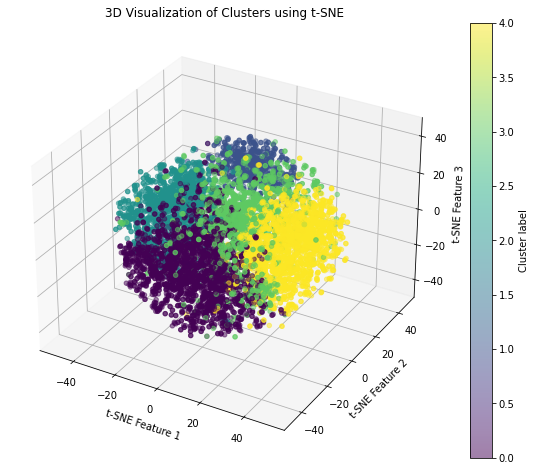

In [41]:
# Applying t-SNE to reduce dimensions from 50 to 2 for visualization
tsne = TSNE(n_components=3, random_state=42)
reduced_features_tsne_3d = tsne.fit_transform(features)

# Plotting the t-SNE output in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features_tsne_3d[:, 0], reduced_features_tsne_3d[:, 1], reduced_features_tsne_3d[:, 2],
                     c=df['cluster'], cmap='viridis', alpha=0.5)

# Adding labels and title
ax.set_title('3D Visualization of Clusters using t-SNE')
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_zlabel('t-SNE Feature 3')

# Color bar to show the cluster colors
fig.colorbar(scatter, ax=ax, label='Cluster label')
plt.show()

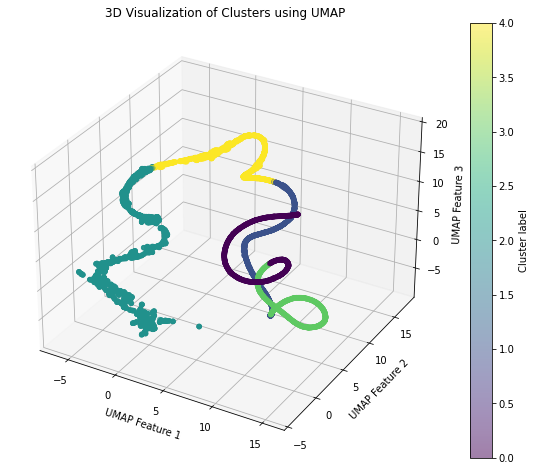

In [17]:
import umap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Configuring UMAP for 3D dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
reduced_features_umap_3d = reducer.fit_transform(reduced_features)

# Plotting the UMAP output in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features_umap_3d[:, 0], reduced_features_umap_3d[:, 1], reduced_features_umap_3d[:, 2],
                     c=df['cluster'], cmap='viridis', alpha=0.5)

# Adding labels and title
ax.set_title('3D Visualization of Clusters using UMAP')
ax.set_xlabel('UMAP Feature 1')
ax.set_ylabel('UMAP Feature 2')
ax.set_zlabel('UMAP Feature 3')

# Color bar to show the cluster colors
fig.colorbar(scatter, ax=ax, label='Cluster label')
plt.show()

In [87]:
df.to_csv("clustering_output.csv")

In [33]:
print(features.dtypes)
print(features[0])  # Display an example feature to inspect its content

Unnamed: 0        int64
feature_0       float64
feature_1       float64
feature_2       float64
feature_3       float64
                 ...   
feature_2044    float64
feature_2045    float64
feature_2046    float64
feature_2047    float64
cluster           int32
Length: 2050, dtype: object


KeyError: 0

In [34]:
feature_columns = [col for col in features.columns if 'feature_' in col]
features_only = features[feature_columns]

In [79]:
# Assuming kmeans has already been fit on the relevant data
centroids = kmeans.cluster_centers_
df['cluster'] = clusters  # make sure this is included after clustering
distances = [np.linalg.norm(features_only.iloc[i] - centroids[cluster]) for i, cluster in enumerate(clusters)]
df['distance_to_centroid'] = distances

In [85]:
#og_df = df
df = og_df

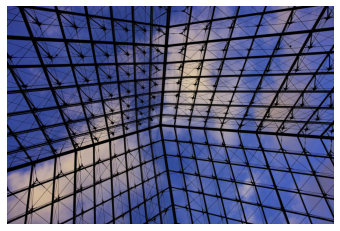

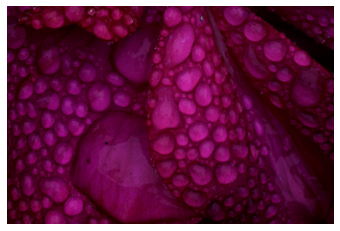

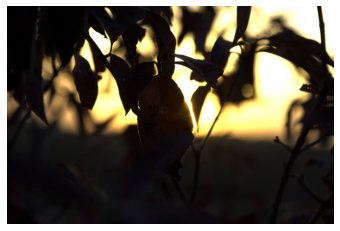

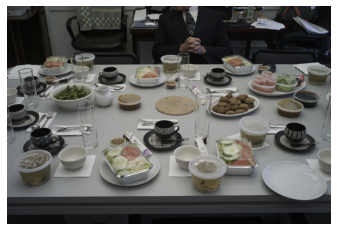

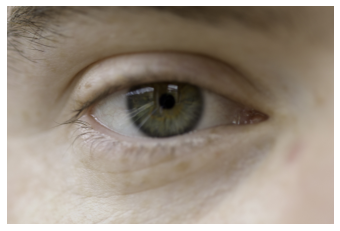

In [64]:
max_distance_filenames = df.loc[df.groupby('cluster')['distance_to_centroid'].idxmax(), ['filename']]
for filename in max_distance_filenames['filename']:
    # Construct the full file path
    file_path = "/kaggle/input/adobe-fivek/a/" + filename
    try:
        # Open the image file using PIL
        img = Image.open(file_path)
        # Display the image using matplotlib
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {file_path}")

In [66]:
filtered_df = df[df['cluster'].isin([1,3])]
filtered_df

filename  feature_0  feature_1  \
0                                a1380-jmac_DSC0493.jpg   0.847715   0.552176   
1              a3202-07-06-02-at-13h18m43-s_MG_1425.jpg   0.151609   1.161677   
10                                    a2612-dgw_115.jpg   2.514485   1.059994   
12                                 a0842-tc_DSC2360.jpg   1.347739   2.583760   
14                                   a2874-IMG_4365.jpg   2.335889   0.189271   
...                                                 ...        ...        ...   
9485               a2520-dgw_143.jpg_motion_blurred.jpg   2.734417   0.315522   
9486                   a3572-_DGW6384.jpg_pixelated.jpg   1.784508   0.178668   
9487  a3202-07-06-02-at-13h18m43-s_MG_1425.jpg_grain...   0.287407   1.444354   
9490                  a3851-IMG_3430.jpg_lens_flare.jpg   0.424635   0.504053   
9498                   a2726-kme_277.jpg_lens_flare.jpg   1.193474   2.652497   

      feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0      1.155910   0.593454   0.535424   0.902732   0.479701   0.540000   
1      0.236279   1.201173   0.680420   1.322529   0.639451   1.236349   
10     2.262731   0.105400   0.509325   0.065227   0.261542   0.465664   
12     0.216309   0.004597   0.336847   1.821559   0.507798   0.577592   
14     1.835682   0.521112   0.093298   0.235415   0.000000   0.000000   
...         ...        ...        ...        ...        ...        ...   
9485   0.603671   0.159223   0.002261   0.707215   0.536456   0.152830   
9486   1.214117   0.468243   0.010533   0.000000   0.105852   0.438982   
9487   0.022166   1.195609   0.884622   0.780561   0.637840   0.641154   
9490   0.156067   0.222809   1.837106   0.021240   0.059476   0.722319   
9498   0.165280   2.340047   0.236165   1.565924   0.626812   0.578797   

      feature_8  ...  feature_2040  feature_2041  feature_2042  feature_2043  \
0      1.972688  ...      2.205877      0.313320      0.332020      0.241766   
1      1.000782  ...      1.100954      1.144634      0.201663      0.005133   
10     0.718048  ...      0.388161      0.019658      0.017319      0.956841   
12     0.543607  ...      0.198022      0.098743      0.137461      0.597904   
14     0.468486  ...      0.005731      0.061993      0.106912      1.059877   
...         ...  ...           ...           ...           ...           ...   
9485   0.329074  ...      0.145579      0.003395      0.076660      0.414240   
9486   0.044214  ...      0.005790      0.010872      0.000000      0.216372   
9487   0.603385  ...      0.749767      1.093937      0.041515      0.000000   
9490   0.000000  ...      1.042196      1.038734      0.126418      0.557726   
9498   3.854193  ...      0.000000      0.001689      0.464067      0.714830   

      feature_2044  feature_2045  feature_2046  feature_2047  cluster  \
0         2.745939      0.271787      0.406695      0.141644        3   
1         0.611328      1.198680      0.241484      0.178305        3   
10        0.000000      0.112575      0.954263      0.188156        1   
12        0.107335      0.003841      0.070395      0.000000        3   
14        0.000000      0.000000      0.000000      0.168086        1   
...            ...           ...           ...           ...      ...   
9485      0.004427      0.333321      1.430324      0.094445        1   
9486      0.705637      0.482636      0.402921      0.179536        1   
9487      0.905801      0.702628      0.405639      0.355354        3   
9490      0.605371      0.166500      0.274519      0.281346        3   
9498      0.029037      1.195534      2.301097      1.513492        3   

      distance_to_centroid  
0                31.211602  
1                26.714785  
10               32.841394  
12               32.203338  
14               25.950405  
...                    ...  
9485             27.079949  
9486             27.802628  
9487             28.217947  
9490             34.063407  
9498             54.981974  

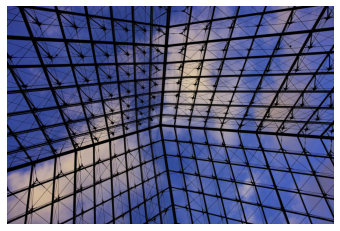

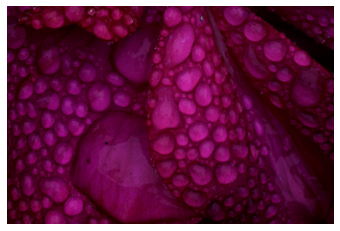

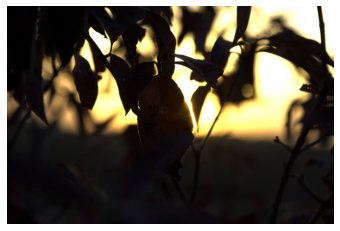

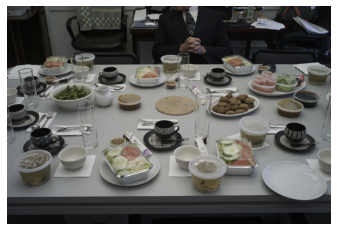

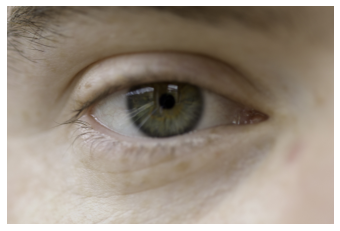

Enter the images to delete; comma separated from 1-5. enter 6 to not delete any image
 4


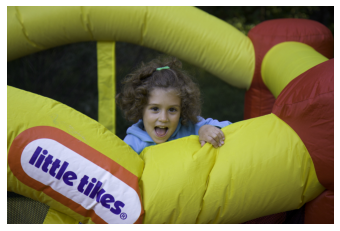

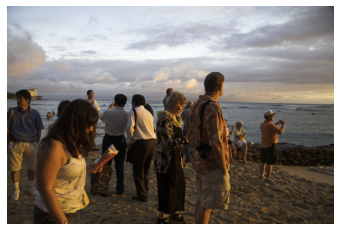

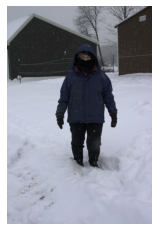

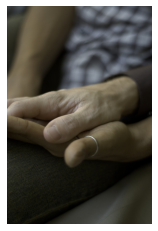

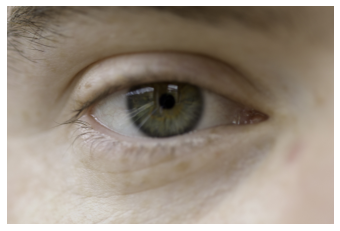

Enter the images to delete; comma separated from 1-5. enter 6 to not delete any image
 1


File not found: /kaggle/input/adobe-fivek/a/a0244-GrassleyCase-5393.jpg_grainy.jpg


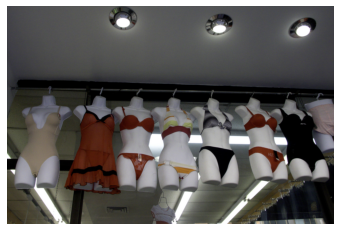

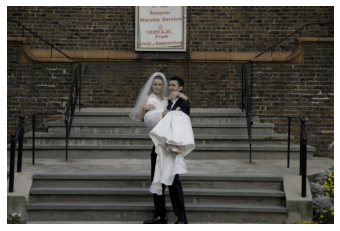

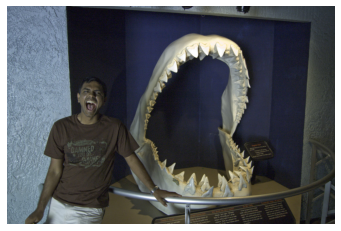

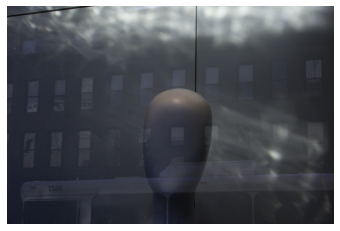

Enter the images to delete; comma separated from 1-5. enter 6 to not delete any image
 2


File not found: /kaggle/input/adobe-fivek/a/a1552-jmac_DSC3309.jpg_lens_flare.jpg


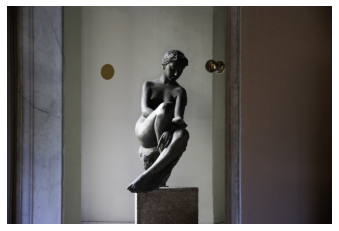

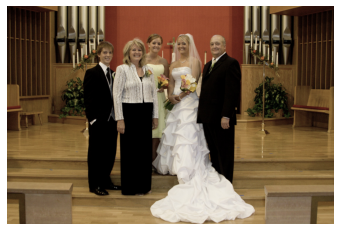

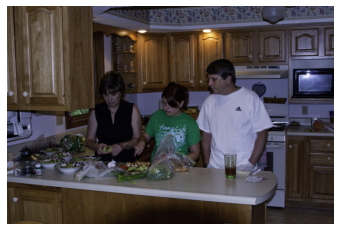

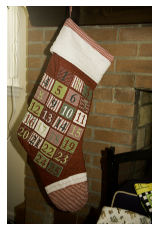

Enter the images to delete; comma separated from 1-5. enter 6 to not delete any image
 4


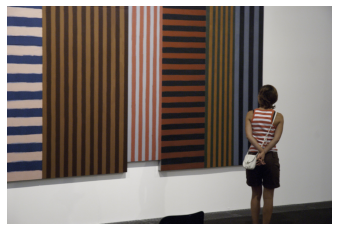

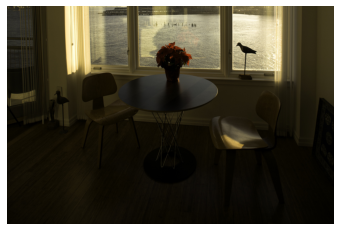

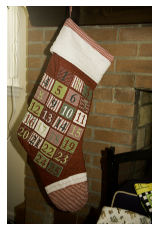

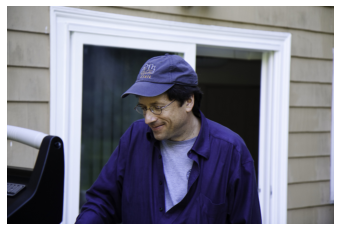

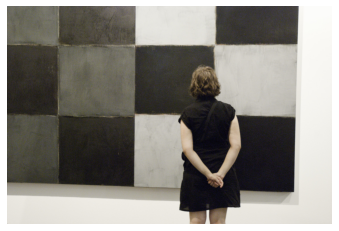

In [ ]:
def recommendation_system(df):
    df = df.drop(['cluster', 'distance_to_centroid'], axis=1)
    kmeans = KMeans(n_clusters=5, random_state=42)
    features_only = df.drop(['filename'], axis=1)
    clusters = kmeans.fit_predict(features_only)
    centroids = kmeans.cluster_centers_
    df['cluster'] = clusters
    distances = [np.linalg.norm(features_only.iloc[i] - centroids[cluster]) for i, cluster in enumerate(clusters)]
    df['distance_to_centroid'] = distances
    return df, clusters

while True:
    # Assuming df is defined elsewhere and properly initialized
    max_distance_filenames = df.loc[df.groupby('cluster')['distance_to_centroid'].idxmax(), ['filename']]
    for filename in max_distance_filenames['filename']:
        file_path = "/kaggle/input/adobe-fivek/a/" + filename  # Adjust path as necessary
        try:
            img = Image.open(file_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except FileNotFoundError:
            print(f"File not found: {file_path}")

    user_input = input("Enter the images to delete; comma separated from 1-5. enter 6 to not delete any image\n")
    numbers = [int(x.strip()) for x in user_input.split(',')]
    if 6 in numbers:
        break
    # Assuming you need to process based on cluster numbers
    for n in numbers:
        df = df[df['filename'] != filename[n-1]]
    df, clusters = recommendation_system(df[df['cluster'].isin(numbers)])